In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.1 MB/s eta 0:00:00


In [7]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns


In [9]:

random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)


In [10]:
# Load the CSV file into a pandas DataFrame
df = pd.read_csv('Sentiment_news_dataframe.csv')


In [11]:
# Drop irrelevant columns
df = df.drop(['Date', 'URL', 'confidence', 'Unnamed: 5'], axis=1)


In [12]:
# Drop duplicates in column "Title"
df = df.drop_duplicates(subset=["Title"])


In [13]:
# Rename columns
df = df.rename(columns={'Title': 'text', 'sentiment': 'Label'})

In [14]:
# Convert labels to integers
df['Label'] = df['Label'].apply(lambda x: 1 if x == "POSITIVE" else 0)


In [15]:
# Split the dataset into training and validation sets
train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)


In [16]:
# Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [17]:
# Encode the training and validation sets
train_encodings = tokenizer(list(train_df['text']), truncation=True, padding=True)
val_encodings = tokenizer(list(val_df['text']), truncation=True, padding=True)


In [18]:
# Convert the input encodings to TensorFlow tensors
train_inputs = {key: tf.convert_to_tensor(val) for key, val in train_encodings.items()}
val_inputs = {key: tf.convert_to_tensor(val) for key, val in val_encodings.items()}


In [19]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_df['Label']))
val_dataset = tf.data.Dataset.from_tensor_slices((val_inputs, val_df['Label']))


In [20]:
# Load the pre-trained DistilBERT model
modeldtbert = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [21]:
# Set up the optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [22]:
# Compile the model
modeldtbert.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


In [23]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)


In [24]:
# Train the model
modeldtbert.fit(train_dataset.shuffle(len(train_df)).batch(32), epochs=5, batch_size=32, validation_data=val_dataset.batch(32), callbacks=[early_stopping])

Epoch 1/5
1500/1500 [==============================] - 121s 62ms/step - loss: 0.3647 - accuracy: 0.8324 - val_loss: 0.3089 - val_accuracy: 0.8604
Epoch 2/5
1500/1500 [==============================] - 69s 46ms/step - loss: 0.1955 - accuracy: 0.9204 - val_loss: 0.3402 - val_accuracy: 0.8573
Epoch 3/5
1500/1500 [==============================] - 68s 45ms/step - loss: 0.0983 - accuracy: 0.9630 - val_loss: 0.4102 - val_accuracy: 0.8564
Epoch 3: early stopping


In [25]:
# Evaluate the model on the training set
train_loss, train_acc = modeldtbert.evaluate(train_dataset.batch(32))
print("Train accuracy of DistilBert:", train_acc)


1500/1500 [==============================] - 29s 18ms/step - loss: 0.1807 - accuracy: 0.9423
Train accuracy of DistilBert: 0.9423068761825562


In [26]:
# Evaluate the model on the validation set
val_loss, val_acc = modeldtbert.evaluate(val_dataset.batch(32))
print("Test accuracy of DistilBert:", val_acc)


375/375 [==============================] - 7s 18ms/step - loss: 0.3089 - accuracy: 0.8604
Test accuracy of DistilBert: 0.860358476638794


In [27]:
# Make predictions on the validation set
y_pred = modeldtbert.predict(val_dataset.batch(32)).logits.argmax(axis=1)


375/375 [==============================] - 8s 17ms/step


In [28]:
import pickle

In [29]:
with open('model_dtbert.pkl', 'wb') as f:
    pickle.dump(modeldtbert, f)

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [30]:
# Calculate evaluation metrics
print("\nClassification report of DistilBert:")
print(classification_report(val_df['Label'], y_pred))


Classification report of DistilBert:
              precision    recall  f1-score   support

           0       0.90      0.81      0.86      6091
           1       0.82      0.91      0.87      5904

    accuracy                           0.86     11995
   macro avg       0.86      0.86      0.86     11995
weighted avg       0.86      0.86      0.86     11995



In [31]:


precision, recall, f1_score, _ = precision_recall_fscore_support(val_df['Label'], y_pred, average='binary')

print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1_score)

Precision: 0.82475810167409
Recall: 0.9095528455284553
F1 score: 0.86508256141764


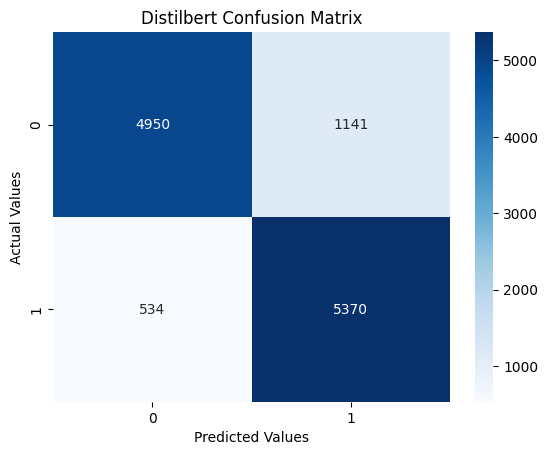

In [32]:
conf_matrix = confusion_matrix(val_df['Label'], y_pred)
# Visualize confusion matrix with heatmap
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Distilbert Confusion Matrix')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

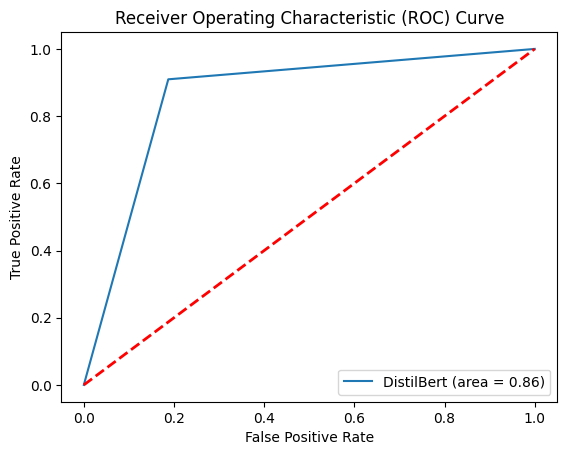

In [33]:
# Calculate ROC curve and AUC

fpr, tpr, thresholds = roc_curve(val_df['Label'], y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'DistilBert (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()